# Modelo ML para predicción de alquiler de bicicletas

---
**Descripción General del Proyecto**

El objetivo de este proyecto es desarrollar e implementar un modelo de regresión lineal capaz de predecir la demanda de bicicletas compartidas por hora, basándose en datos históricos, meteorológicos y de calendario. Este análisis permitirá identificar las variables más influyentes y comprender las relaciones existentes para mejorar la predicción del número de alquileres.

**Importe del Dataset y Librerías**

In [ ]:
!pip install ucimlrepo
!pip install xgboost

import xgboost as xgb
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo #Dataset
np.random.seed(42)  # para reproducibilidad

# fetch dataset
bikes = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bikes.data.features
y = bikes.data.targets

# metadata
print(bikes.metadata)

# variable information
print(bikes.variables)

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'ID': 422, 'type': 'NATIVE', 'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'venue': 'Progress

**Análisis Exploratorio de Datos (EDA)**

Este bloque de código combina las variables predictoras (`X`) y la variable objetivo (`y`) en un único DataFrame llamado `bikes`. Luego, muestra las primeras filas de este nuevo DataFrame para una visualización rápida de los datos combinados.

In [ ]:
# Combine features and target into a single DataFrame
bikes = pd.concat([X, y], axis=1)

# Display the first few rows of the combined DataFrame
display(bikes.head())

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


Este bloque de código imprime el número de filas y columnas del DataFrame `bikes`, los nombres de las columnas, verifica si hay valores nulos en cada columna y muestra un resumen estadístico descriptivo de las columnas numéricas.

In [ ]:
print("Filas / Columnas: ", bikes.shape)
print("\nColumnas: ", list(bikes.columns))
print("\nNulos por columna: ", bikes.isna().sum())
bikes.describe().T

Filas / Columnas:  (17379, 14)

Columnas:  ['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

Nulos por columna:  dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000


Este bloque de código genera histogramas para visualizar la distribución de las columnas numéricas en el DataFrame `bikes`, excluyendo la variable objetivo 'cnt'.

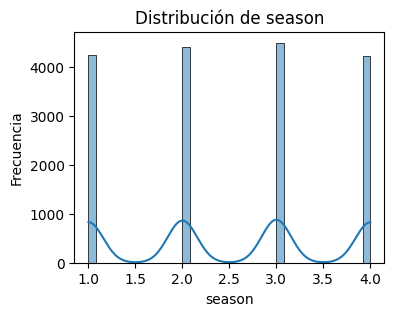

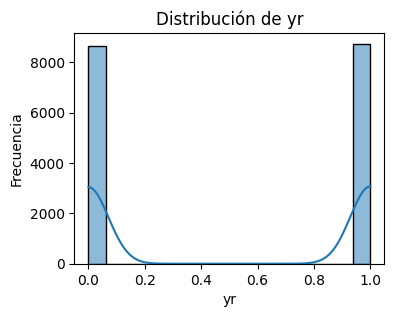

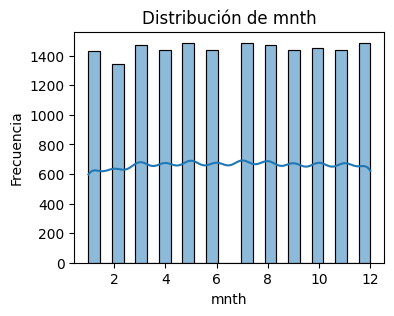

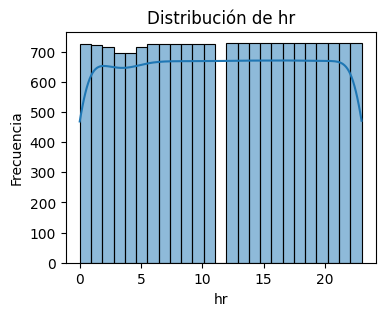

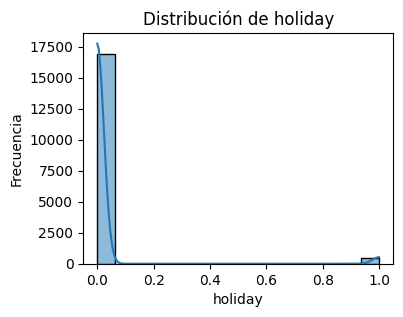

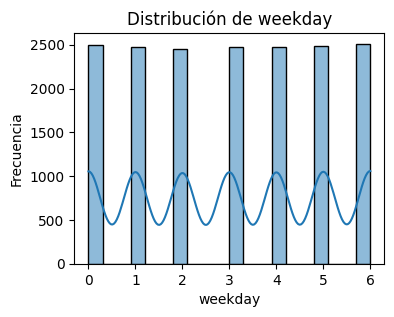

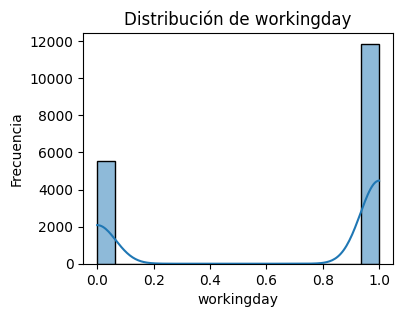

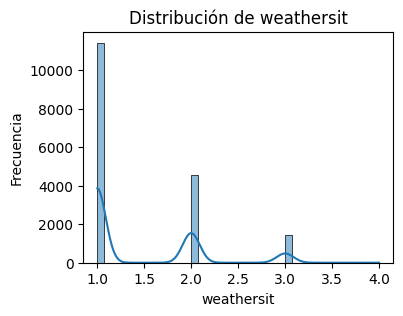

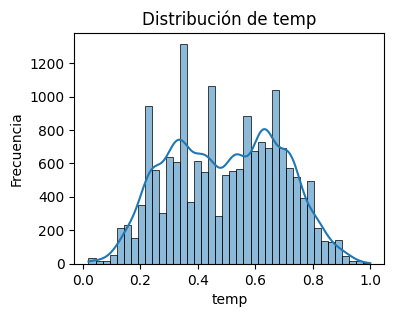

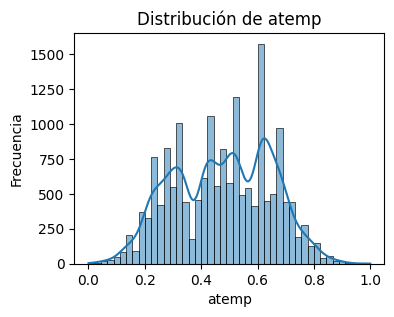

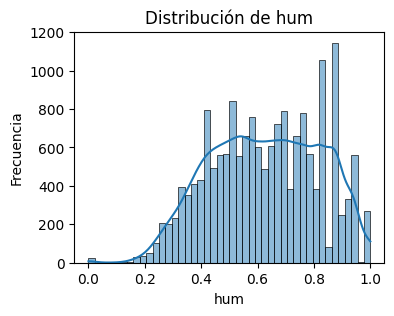

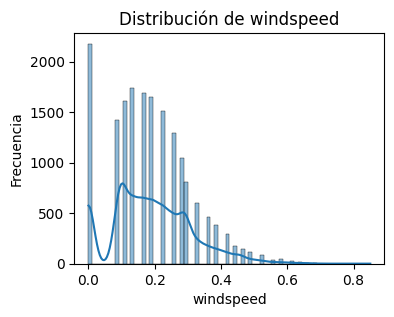

In [ ]:
# Plot histograms for numerical columns
numerical_cols = bikes.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('cnt') # Exclude the target variable

for col in numerical_cols:
    plt.figure(figsize=(4, 3))
    sns.histplot(data=bikes, x=col, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

**Separación muestras Train/Test**

Este bloque de código realiza la separación del DataFrame `bikes` en conjuntos de entrenamiento y prueba (`X_train`, `X_test`, `y_train`, `y_test`) utilizando `train_test_split` de scikit-learn. Se especifica un tamaño de prueba del 20% y se excluye la columna 'dteday' de las características. Finalmente, imprime las dimensiones de los conjuntos resultantes.

In [ ]:
X = bikes.drop(columns=['cnt',"dteday"])
y = bikes['cnt']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Tamaños:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)

Tamaños:
X_train: (13903, 12) | X_test: (3476, 12)


**Modelo de regresión lineal**



Este bloque de código implementa un modelo de Regresión Lineal simple para predecir el número de alquileres de bicicletas. Entrena el modelo con los datos de entrenamiento y realiza predicciones en los conjuntos de entrenamiento y prueba para evaluar su rendimiento inicial.

In [ ]:
lin_reg = LinearRegression() #Creación del modelo
lin_reg.fit(X_train, y_train) #Se pasan los datos de entrenamiento

y_pred_train = lin_reg.predict(X_train) #Se realizan predicciones en Train/Test
y_pred_test  = lin_reg.predict(X_test)

def evaluar(y_true, y_pred, nombre="Bikes_LR"):
    mae = mean_absolute_error(y_true, y_pred)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False) #Si tu sklearn es moderno
    except TypeError:
        rmse = mean_squared_error(y_true, y_pred) ** 0.5 #Compatibilidad con versiones viejas
    r2 = r2_score(y_true, y_pred)
    print(f"{nombre} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")


print("Resultados en TRAIN:")
evaluar(y_train, y_pred_train, "Regresión Lineal (train)")

print("\nResultados en TEST:")
evaluar(y_test, y_pred_test, "Regresión Lineal (test)")

Resultados en TRAIN:
Regresión Lineal (train) -> MAE: 106.554 | RMSE: 142.452 | R²: 0.389

Resultados en TEST:
Regresión Lineal (test) -> MAE: 104.803 | RMSE: 139.211 | R²: 0.388


Este bloque de código implementa un `Pipeline` que primero escala las características utilizando `StandardScaler` y luego aplica un modelo de `LinearRegression`. Entrena el pipeline con los datos de entrenamiento escalados y evalúa su rendimiento en el conjunto de prueba escalado.

In [ ]:
pipe_lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("Bikes_LR", LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_test_pipe = pipe_lr.predict(X_test)

evaluar(y_test, y_pred_test_pipe, "Pipeline(StandardScaler + LinearRegression) (test)")

Pipeline(StandardScaler + LinearRegression) (test) -> MAE: 104.803 | RMSE: 139.211 | R²: 0.388


**Decision Tree Regressor**

Un árbol de decisión es un modelo no paramétrico que aprende reglas de decisión simples a partir de los datos y las utiliza para predecir un valor objetivo.

In [ ]:
# Implementación de Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Realizar predicciones en Train y Test
y_pred_train_dt = dt_reg.predict(X_train)
y_pred_test_dt = dt_reg.predict(X_test)


print("Resultados en TRAIN (Decision Tree Regressor):")
evaluar(y_train, y_pred_train_dt, "Decision Tree Regressor (train)")

print("\nResultados en TEST (Decision Tree Regressor):")
evaluar(y_test, y_pred_test_dt, "Decision Tree Regressor (test)")

Resultados en TRAIN (Decision Tree Regressor):
Decision Tree Regressor (train) -> MAE: 0.015 | RMSE: 0.599 | R²: 1.000

Resultados en TEST (Decision Tree Regressor):
Decision Tree Regressor (test) -> MAE: 34.180 | RMSE: 58.249 | R²: 0.893


**Random Forest Regressor**

Un bosque aleatorio es un modelo de conjunto que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste.

In [ ]:
# Implementación de Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Realizar predicciones en Train
y_pred_train_rf = rf_reg.predict(X_train)

print("Resultados en TRAIN (Random Forest Regressor):")
evaluar(y_train, y_pred_train_rf, "Random Forest Regressor (train)")

# Realizar predicciones en Test
y_pred_test_rf = rf_reg.predict(X_test)

print("\nResultados en TEST (Random Forest Regressor):")
evaluar(y_test, y_pred_test_rf, "Random Forest Regressor (test)")

Resultados en TRAIN (Random Forest Regressor):
Random Forest Regressor (train) -> MAE: 9.567 | RMSE: 15.992 | R²: 0.992

Resultados en TEST (Random Forest Regressor):
Random Forest Regressor (test) -> MAE: 24.903 | RMSE: 42.069 | R²: 0.944


**XGBoost Regressor**

XGBoost (Extreme Gradient Boosting) es un algoritmo de boosting muy eficiente y popular que utiliza árboles de decisión en secuencia, donde cada nuevo árbol corrige los errores del anterior. Es conocido por su alto rendimiento y velocidad.

In [ ]:
# Implementación de XGBoost Regressor
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Realizar predicciones en Train y Test
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_test_xgb = xgb_reg.predict(X_test)

print("Resultados en TEST (XGBoost Regressor):")
evaluar(y_test, y_pred_test_xgb, "XGBoost Regressor (test)")

print("Resultados en TRAIN (XGBoost Regressor):")
evaluar(y_train, y_pred_train_xgb, "XGBoost Regressor (train)")

Resultados en TEST (XGBoost Regressor):
XGBoost Regressor (test) -> MAE: 25.010 | RMSE: 40.241 | R²: 0.949
Resultados en TRAIN (XGBoost Regressor):
XGBoost Regressor (train) -> MAE: 18.001 | RMSE: 27.784 | R²: 0.977


**Optimización de Hiperparámetros para XGBoost (Mitigación de Overfitting)**

Para abordar el posible sobreajuste y mejorar la generalización del modelo XGBoost, utilizaremos `GridSearchCV` para buscar la mejor combinación de hiperparámetros relacionados con la regularización, la complejidad del árbol y el subsampling, incorporando Early Stopping.

In [ ]:
# Definir el modelo XGBoost
xgb_reg_tuned = xgb.XGBRegressor(random_state=42, objective='reg:squarederror') # Usamos 'reg:squarederror' para regresión

# Definir el espacio de búsqueda de hiperparámetros
# Incluimos parámetros para regularización, complejidad del árbol y subsampling
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'lambda': [0.1, 1, 10], # Regularización L2
    'alpha': [0.1, 1, 10]  # Regularización L1
}

# Configurar GridSearchCV con validación cruzada
# Usaremos neg_mean_squared_error como métrica de evaluación (GridSearchCV maximiza, por eso es negativo)
# Se pueden añadir callbacks para early stopping si se usa fit con un conjunto de evaluación
grid_search = GridSearchCV(estimator=xgb_reg_tuned, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV a los datos de entrenamiento
# Para implementar early stopping dentro de GridSearchCV, necesitaríamos un conjunto de validación separado
# o usar la API de XGBoost directamente con un conjunto de evaluación.
# En este ejemplo, nos centraremos en la búsqueda de hiperparámetros con CV.
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_xgb_reg = grid_search.best_estimator_
y_pred_test_tuned_xgb = best_xgb_reg.predict(X_test)

print("\nResultados en TEST (XGBoost Regressor optimizado):")
evaluar(y_test, y_pred_test_tuned_xgb, "XGBoost Regressor optimizado (test)")

# Evaluar en entrenamiento para comparar
y_pred_train_tuned_xgb = best_xgb_reg.predict(X_train)
print("\nResultados en TRAIN (XGBoost Regressor optimizado):")
evaluar(y_train, y_pred_train_tuned_xgb, "XGBoost Regressor optimizado (train)")

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Mejores hiperparámetros encontrados:
{'alpha': 10, 'colsample_bytree': 0.8, 'lambda': 10, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Resultados en TEST (XGBoost Regressor optimizado):
XGBoost Regressor optimizado (test) -> MAE: 22.970 | RMSE: 37.417 | R²: 0.956

Resultados en TRAIN (XGBoost Regressor optimizado):
XGBoost Regressor optimizado (train) -> MAE: 15.467 | RMSE: 24.045 | R²: 0.983


**Análisis de Residuos y Predicciones del Modelo**

Este bloque de código genera dos gráficos para analizar el rendimiento del modelo de Regresión Lineal: un gráfico de dispersión de valores reales versus valores predichos y un gráfico de residuos para evaluar la distribución de los errores.

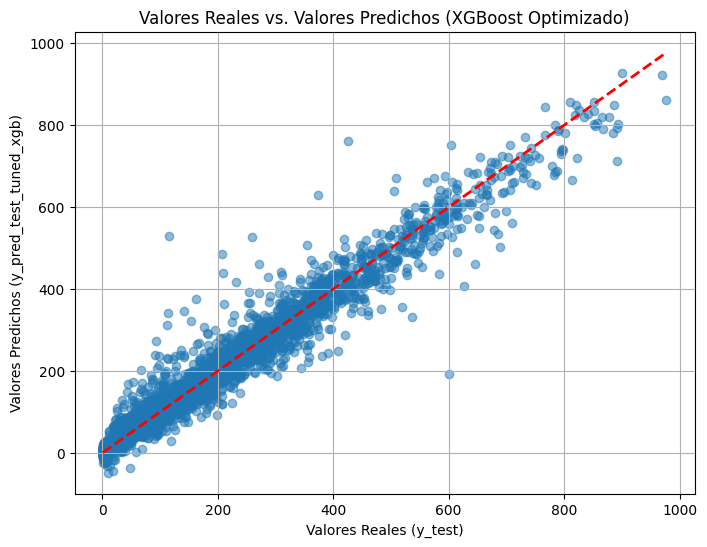

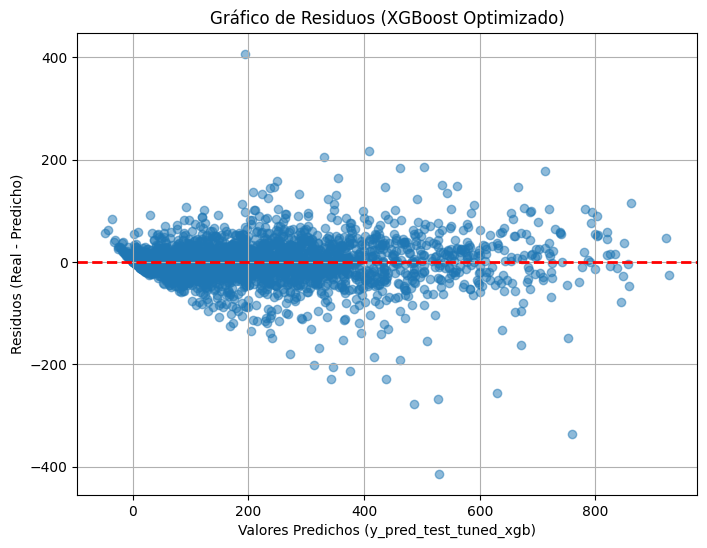

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de Valores Reales vs. Valores Predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_tuned_xgb, alpha=0.5) # Usamos las predicciones del XGBoost optimizado
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea diagonal perfecta
plt.xlabel("Valores Reales (y_test)")
plt.ylabel("Valores Predichos (y_pred_test_tuned_xgb)")
plt.title("Valores Reales vs. Valores Predichos (XGBoost Optimizado)")
plt.grid(True)
plt.show()

# Gráfico de Residuos
residuos = y_test - y_pred_test_tuned_xgb
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test_tuned_xgb, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Línea horizontal en cero
plt.xlabel("Valores Predichos (y_pred_test_tuned_xgb)")
plt.ylabel("Residuos (Real - Predicho)")
plt.title("Gráfico de Residuos (XGBoost Optimizado)")
plt.grid(True)
plt.show()